# Data Analysis and Exploration

This notebook analyzes real world data to examine the gravity-longevity hypothesis using country-level data from World Bank sources.

## Analysis Overview

1. Load and examine real world dataset
2. Calculate correlations between gravity and life expectancy
3. Compare Blue Zone regions to other countries
4. Perform multiple regression to control for confounders
5. Generate visualizations and statistical tests

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Set plotting style
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

## Data Loading and Preparation

In [2]:
def load_real_data():
    """
    Load the real world data from analysis outputs
    """
    # Try real data files in order of preference
    data_files = [
        '../outputs/cross_section_final.csv',
        '../outputs/final_processed_data.csv', 
        '../outputs/comprehensive_panel_data.csv'
    ]
    
    for data_file in data_files:
        if os.path.exists(data_file):
            df = pd.read_csv(data_file)
            print(f"Loaded real data from: {data_file}")
            print(f"Shape: {df.shape}")
            
            # Remove rows with missing life expectancy
            df = df[df['life_expectancy'].notna()]
            return df
    
    raise FileNotFoundError("No real data files found. Run the Python analysis scripts first to generate data.")

# Load dataset
df = load_real_data()

if df is not None:
    print(f"Loaded {len(df)} regions with real data")
    print(f"Blue zone regions: {df['is_blue_zone'].sum()}")
    print(f"\nDataset shape: {df.shape}")
    print(f"\nColumns: {list(df.columns)}")
else:
    print("Failed to load data")

Loaded real data from: ../outputs/cross_section_final.csv
Shape: (100, 19)
Loaded 100 regions with real data
Blue zone regions: 5

Dataset shape: (100, 19)

Columns: ['geo_id', 'year', 'latitude', 'longitude', 'elevation', 'is_blue_zone', 'life_expectancy', 'cvd_mortality', 'walkability_score', 'greenspace_pct', 'gdp_per_capita', 'population_density_log', 'temperature_mean', 'effective_gravity', 'gravity_deviation', 'gravity_deviation_pct', 'equatorial_distance', 'gravity_x_walkability_score', 'lifetime_gravity_exposure']


In [3]:
# Display basic dataset information
if df is not None:
    print("Dataset Overview:")
    print("=" * 30)
    print(df.info())
    print("\nSummary Statistics:")
    print("=" * 30)
    display(df.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   geo_id                       100 non-null    object 
 1   year                         100 non-null    int64  
 2   latitude                     100 non-null    float64
 3   longitude                    100 non-null    float64
 4   elevation                    100 non-null    float64
 5   is_blue_zone                 100 non-null    int64  
 6   life_expectancy              100 non-null    float64
 7   cvd_mortality                100 non-null    float64
 8   walkability_score            100 non-null    float64
 9   greenspace_pct               100 non-null    float64
 10  gdp_per_capita               100 non-null    float64
 11  population_density_log       100 non-null    float64
 12  temperature_mean             100 non-null    float64
 13  eff

,year,latitude,longitude,elevation,is_blue_zone,life_expectancy,cvd_mortality,walkability_score,greenspace_pct,gdp_per_capita,population_density_log,temperature_mean,effective_gravity,gravity_deviation,gravity_deviation_pct,equatorial_distance,gravity_x_walkability_score,lifetime_gravity_exposure
count,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2000.0,5.558873,2.207097,197.450308,0.050000,75.512285,150.912767,50.462891,29.856387,24958.658343,6.002948,9.874104,9.804154,-0.002496,-0.025451,31.628944,-0.130355,-0.187941
std,0.0,36.175876,112.713246,173.129122,0.219043,3.140278,59.079301,14.614838,9.552757,12797.311649,0.992967,7.455635,0.002722,0.002722,0.027755,18.149716,0.146324,0.205843
min,2000.0,-59.282125,-178.177830,1.395282,0.000000,68.020624,0.000000,10.175788,10.683760,6492.858692,3.769670,-9.865707,9.799575,-0.007075,-0.072143,0.710902,-0.411013,-0.550990
25%,2000.0,-24.045127,-94.804125,55.138381,0.000000,73.511425,106.522057,39.271751,22.787011,15333.997110,5.319928,4.410715,9.801725,-0.004925,-0.050219,15.396720,-0.231315,-0.366727
50%,2000.0,7.402872,5.559062,152.937931,0.000000,75.394192,155.139181,51.185643,29.743711,22266.816716,5.942815,9.723672,9.803603,-0.003047,-0.031071,30.550614,-0.125550,-0.220695
75%,2000.0,35.478199,101.232234,267.949311,0.000000,77.844512,186.555396,59.760936,35.733433,32053.802772,6.712360,14.475089,9.806411,-0.000239,-0.002437,46.264644,-0.009675,-0.017554
max,2000.0,68.707001,174.834163,700.711495,1.000000,83.230744,284.685032,86.582851,58.916587,62181.870867,8.765980,31.653927,9.810211,0.003561,0.036313,68.707001,0.162532,0.269973


## Gravity-Longevity Correlation Analysis

In [4]:
def analyze_gravity_correlation(df):
    """
    Analyze correlation between gravity and longevity using real data
    """
    print("Gravity-Longevity Analysis")
    print("=" * 50)
    
    # Calculate correlations
    correlations = {
        'gravity_vs_life_exp': df['effective_gravity'].corr(df['life_expectancy']),
        'latitude_vs_life_exp': df['latitude'].abs().corr(df['life_expectancy']),
        'gdp_vs_life_exp': df['gdp_per_capita'].corr(df['life_expectancy']) if 'gdp_per_capita' in df.columns else None,
    }
    
    print("\nCorrelation Coefficients:")
    print("-" * 30)
    for name, corr in correlations.items():
        if corr is not None:
            print(f"{name}: r = {corr:.4f}")
    
    return correlations

if df is not None:
    correlations = analyze_gravity_correlation(df)

Gravity-Longevity Analysis

Correlation Coefficients:
------------------------------
gravity_vs_life_exp: r = 0.0628
latitude_vs_life_exp: r = 0.1062
gdp_vs_life_exp: r = -0.1365


In [5]:
# Statistical significance tests
if df is not None:
    print("Statistical Tests:")
    print("-" * 30)
    
    # Gravity vs life expectancy regression
    mask = df['life_expectancy'].notna()
    if mask.sum() > 2:
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            df[mask]['effective_gravity'],
            df[mask]['life_expectancy']
        )
        
        print(f"Gravity Regression Results:")
        print(f"  Slope: {slope:.4f}")
        print(f"  R-squared: {r_value**2:.4f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  Standard Error: {std_err:.4f}")
        
        if p_value < 0.05:
            print(f"  Result: Statistically significant (p < 0.05)")
        else:
            print(f"  Result: Not statistically significant (p >= 0.05)")

Statistical Tests:
------------------------------
Gravity Regression Results:
  Slope: 72.5097
  R-squared: 0.0039
  P-value: 0.5345
  Standard Error: 116.3126
  Result: Not statistically significant (p >= 0.05)


## Blue Zone Comparison Analysis

In [6]:
if df is not None:
    print("Blue Zone vs Other Countries:")
    print("-" * 40)
    
    blue_zones = df[df['is_blue_zone'] == 1]
    others = df[df['is_blue_zone'] == 0]
    
    print(f"Blue Zone Countries: {len(blue_zones)}")
    if len(blue_zones) > 0:
        print(f"  Average Life Expectancy: {blue_zones['life_expectancy'].mean():.1f} years")
        print(f"  Average Gravity: {blue_zones['effective_gravity'].mean():.4f} m/s²")
        print(f"  Standard Deviation: {blue_zones['life_expectancy'].std():.1f} years")
    
    print(f"\nOther Countries: {len(others)}")
    if len(others) > 0:
        print(f"  Average Life Expectancy: {others['life_expectancy'].mean():.1f} years")
        print(f"  Average Gravity: {others['effective_gravity'].mean():.4f} m/s²")
        print(f"  Standard Deviation: {others['life_expectancy'].std():.1f} years")
    
    # Statistical test for difference
    if len(blue_zones) > 0 and len(others) > 0:
        t_stat, p_val = stats.ttest_ind(
            blue_zones['life_expectancy'].dropna(),
            others['life_expectancy'].dropna()
        )
        print(f"\nLife Expectancy Difference Test:")
        print(f"  T-statistic: {t_stat:.4f}")
        print(f"  P-value: {p_val:.4f}")
        
        if p_val < 0.05:
            print(f"  Result: Significant difference between groups")
        else:
            print(f"  Result: No significant difference between groups")

Blue Zone vs Other Countries:
----------------------------------------
Blue Zone Countries: 5
  Average Life Expectancy: 78.2 years
  Average Gravity: 9.8035 m/s²
  Standard Deviation: 1.1 years

Other Countries: 95
  Average Life Expectancy: 75.4 years
  Average Gravity: 9.8042 m/s²
  Standard Deviation: 3.2 years

Life Expectancy Difference Test:
  T-statistic: 2.0145
  P-value: 0.0467
  Result: Significant difference between groups


## Data Visualizations

Creating visualizations...


Visualization saved to ../outputs/figures/real_data_analysis.png


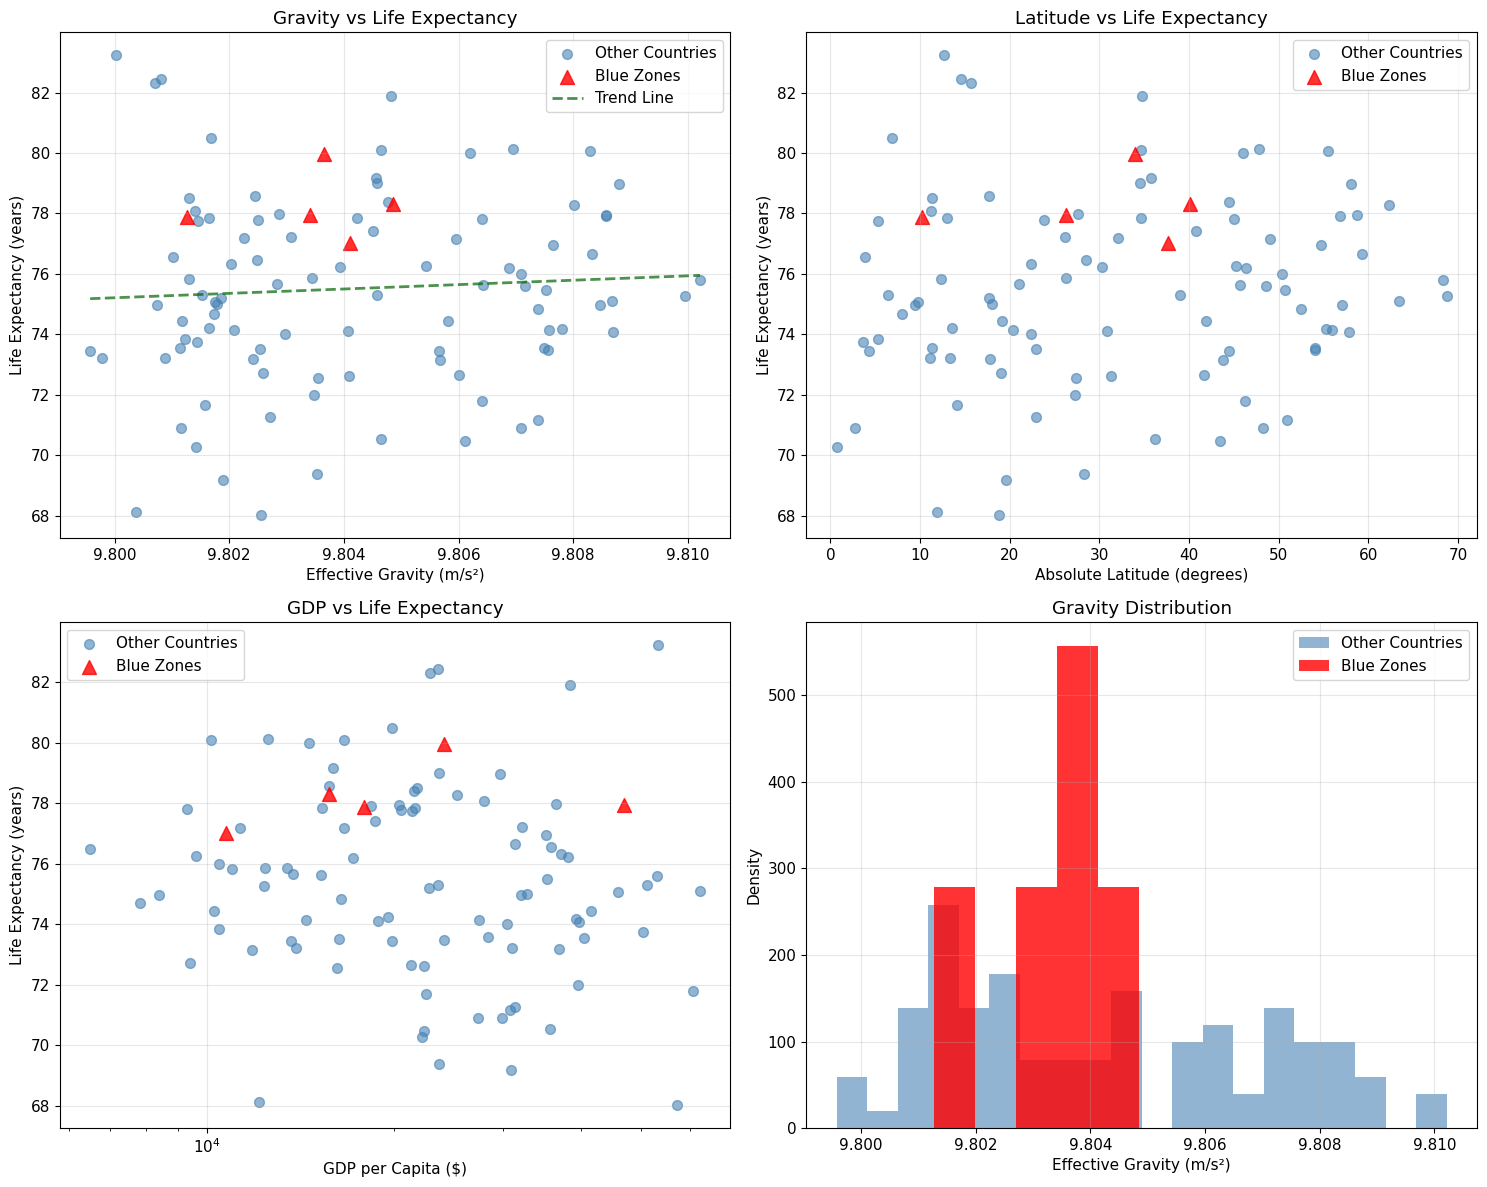

In [7]:
if df is not None:
    print("Creating visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Separate Blue Zones and others
    blue_zones = df[df['is_blue_zone'] == 1]
    others = df[df['is_blue_zone'] == 0]
    
    # 1. Gravity vs Life Expectancy
    ax = axes[0, 0]
    ax.scatter(others['effective_gravity'], others['life_expectancy'], 
              c='steelblue', alpha=0.6, label='Other Countries', s=50)
    if len(blue_zones) > 0:
        ax.scatter(blue_zones['effective_gravity'], blue_zones['life_expectancy'], 
                  c='red', alpha=0.8, label='Blue Zones', s=100, marker='^')
    
    # Add regression line
    mask = df['life_expectancy'].notna()
    if mask.sum() > 2:
        z = np.polyfit(df[mask]['effective_gravity'], df[mask]['life_expectancy'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(df['effective_gravity'].min(), df['effective_gravity'].max(), 100)
        ax.plot(x_line, p(x_line), 'darkgreen', linestyle='--', alpha=0.7, linewidth=2, label='Trend Line')
    
    ax.set_xlabel('Effective Gravity (m/s²)')
    ax.set_ylabel('Life Expectancy (years)')
    ax.set_title('Gravity vs Life Expectancy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Latitude vs Life Expectancy
    ax = axes[0, 1]
    ax.scatter(others['latitude'].abs(), others['life_expectancy'], 
              c='steelblue', alpha=0.6, label='Other Countries', s=50)
    if len(blue_zones) > 0:
        ax.scatter(blue_zones['latitude'].abs(), blue_zones['life_expectancy'], 
                  c='red', alpha=0.8, label='Blue Zones', s=100, marker='^')
    
    ax.set_xlabel('Absolute Latitude (degrees)')
    ax.set_ylabel('Life Expectancy (years)')
    ax.set_title('Latitude vs Life Expectancy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. GDP vs Life Expectancy
    ax = axes[1, 0]
    if 'gdp_per_capita' in df.columns:
        gdp_mask = df['gdp_per_capita'].notna() & df['life_expectancy'].notna()
        if gdp_mask.sum() > 0:
            gdp_others = df[(df['is_blue_zone'] == 0) & gdp_mask]
            gdp_blue = df[(df['is_blue_zone'] == 1) & gdp_mask]
            
            ax.scatter(gdp_others['gdp_per_capita'], gdp_others['life_expectancy'], 
                      c='steelblue', alpha=0.6, label='Other Countries', s=50)
            if len(gdp_blue) > 0:
                ax.scatter(gdp_blue['gdp_per_capita'], gdp_blue['life_expectancy'], 
                          c='red', alpha=0.8, label='Blue Zones', s=100, marker='^')
            
            ax.set_xlabel('GDP per Capita ($)')
            ax.set_ylabel('Life Expectancy (years)')
            ax.set_title('GDP vs Life Expectancy')
            ax.set_xscale('log')
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    # 4. Gravity Distribution
    ax = axes[1, 1]
    ax.hist(others['effective_gravity'], bins=20, alpha=0.6, 
           label='Other Countries', color='steelblue', density=True)
    if len(blue_zones) > 0:
        ax.hist(blue_zones['effective_gravity'], bins=5, alpha=0.8, 
               label='Blue Zones', color='red', density=True)
    
    ax.set_xlabel('Effective Gravity (m/s²)')
    ax.set_ylabel('Density')
    ax.set_title('Gravity Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save figure
    output_dir = '../outputs/figures'
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, 'real_data_analysis.png'), dpi=300, bbox_inches='tight')
    print(f"Visualization saved to {output_dir}/real_data_analysis.png")
    
    plt.show()

## Multiple Regression Analysis

In [8]:
def multiple_regression_analysis(df):
    """
    Multiple regression to control for confounders
    """
    print("Multiple Regression Analysis:")
    print("-" * 40)
    
    # Define potential features
    features = ['effective_gravity', 'gdp_per_capita', 'urban_pop_pct', 'health_exp_per_capita']
    
    # Check which features are available
    available_features = [f for f in features if f in df.columns]
    
    if len(available_features) == 0:
        print("No suitable features found for regression")
        return None
    
    # Create clean dataset
    clean_df = df[available_features + ['life_expectancy']].dropna()
    
    if len(clean_df) < 10:
        print("Insufficient data for multiple regression (need at least 10 observations)")
        return None
    
    print(f"Using {len(clean_df)} countries with complete data")
    print(f"Features: {', '.join(available_features)}")
    
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(clean_df[available_features])
    y = clean_df['life_expectancy'].values
    
    # Fit model
    model = LinearRegression()
    model.fit(X, y)
    
    # Calculate metrics
    r2 = model.score(X, y)
    y_pred = model.predict(X)
    
    print(f"\nModel Results:")
    print(f"R-squared: {r2:.4f}")
    print(f"\nStandardized Coefficients:")
    
    for feature, coef in zip(available_features, model.coef_):
        print(f"  {feature}: {coef:.4f}")
    
    # Calculate additional statistics
    n = len(clean_df)
    k = len(available_features)
    
    # Residual analysis
    residuals = y - y_pred
    rss = np.sum(residuals ** 2)
    mse = rss / (n - k - 1)
    rmse = np.sqrt(mse)
    
    print(f"\nModel Diagnostics:")
    print(f"Root Mean Square Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {np.mean(np.abs(residuals)):.4f}")
    
    return model, clean_df, available_features

if df is not None:
    regression_results = multiple_regression_analysis(df)

Multiple Regression Analysis:
----------------------------------------
Using 100 countries with complete data
Features: effective_gravity, gdp_per_capita

Model Results:
R-squared: 0.0229

Standardized Coefficients:
  effective_gravity: 0.2030
  gdp_per_capita: -0.4297

Model Diagnostics:
Root Mean Square Error: 3.1360
Mean Absolute Error: 2.4457


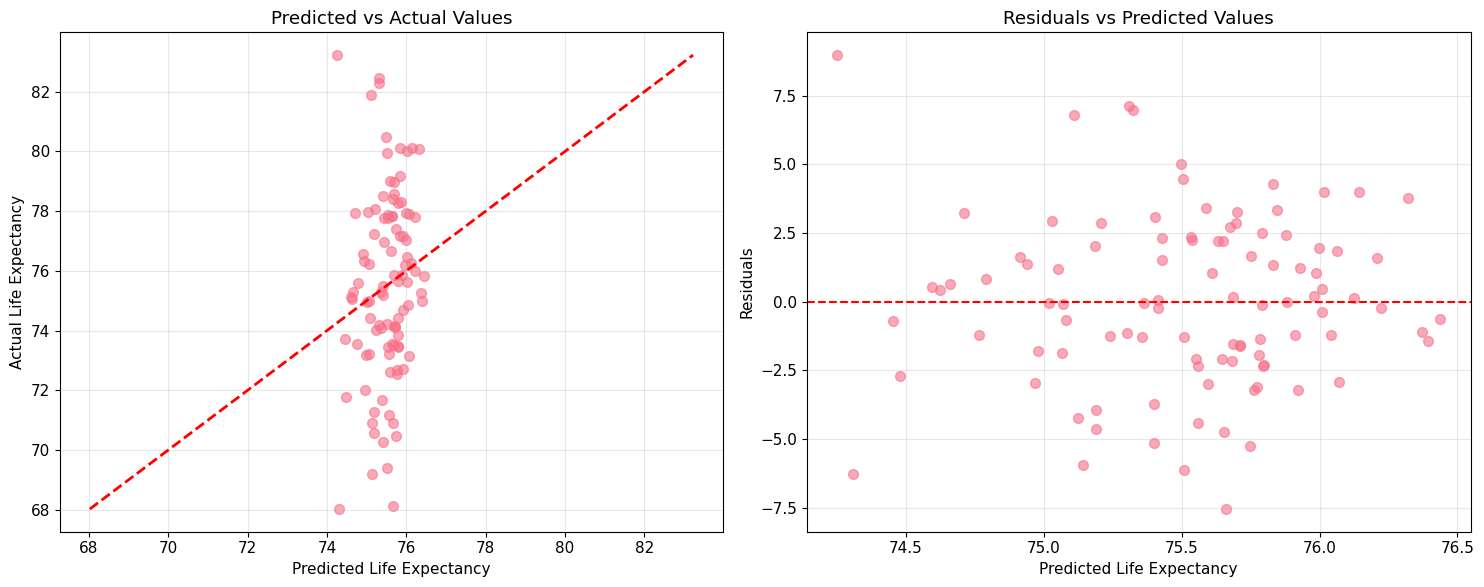

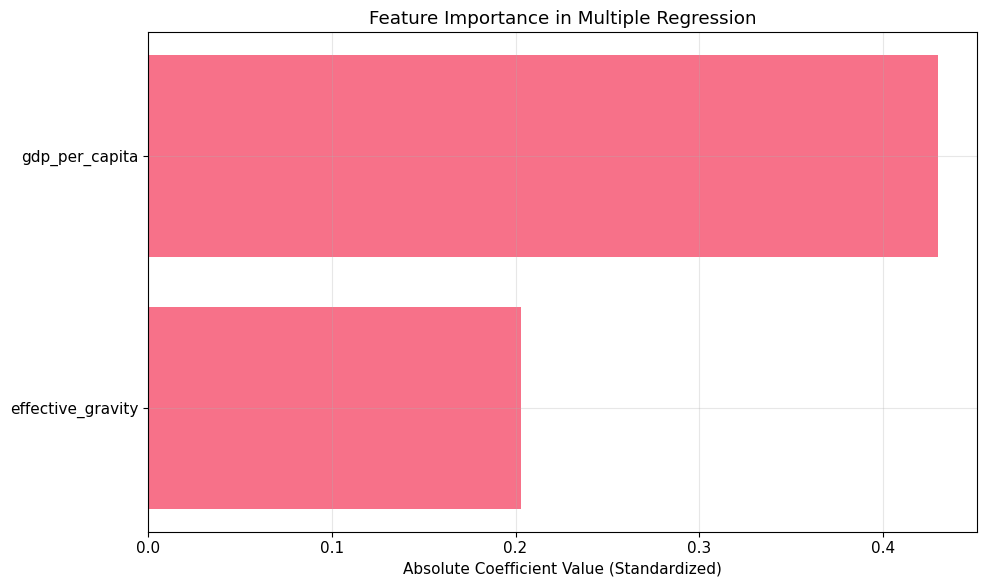

In [9]:
# Residual plots for regression diagnostics
if df is not None and regression_results is not None:
    model, clean_df, available_features = regression_results
    
    # Prepare data for plotting
    scaler = StandardScaler()
    X = scaler.fit_transform(clean_df[available_features])
    y = clean_df['life_expectancy'].values
    y_pred = model.predict(X)
    residuals = y - y_pred
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Predicted vs Actual
    ax = axes[0]
    ax.scatter(y_pred, y, alpha=0.6, s=50)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    ax.set_xlabel('Predicted Life Expectancy')
    ax.set_ylabel('Actual Life Expectancy')
    ax.set_title('Predicted vs Actual Values')
    ax.grid(True, alpha=0.3)
    
    # Residuals vs Predicted
    ax = axes[1]
    ax.scatter(y_pred, residuals, alpha=0.6, s=50)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_xlabel('Predicted Life Expectancy')
    ax.set_ylabel('Residuals')
    ax.set_title('Residuals vs Predicted Values')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Feature importance visualization
    plt.figure(figsize=(10, 6))
    coef_abs = np.abs(model.coef_)
    plt.barh(available_features, coef_abs)
    plt.xlabel('Absolute Coefficient Value (Standardized)')
    plt.title('Feature Importance in Multiple Regression')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Results Summary and Conclusions

In [10]:
if df is not None:
    print("=" * 60)
    print("ANALYSIS CONCLUSIONS")
    print("=" * 60)
    
    # Gravity effect assessment
    if 'gravity_vs_life_exp' in correlations and correlations['gravity_vs_life_exp'] is not None:
        strength = abs(correlations['gravity_vs_life_exp'])
        print(f"\n1. Gravity Effect Assessment:")
        print(f"   Correlation coefficient: r = {correlations['gravity_vs_life_exp']:.4f}")
        
        if strength < 0.1:
            effect_size = "negligible (r < 0.1)"
        elif strength < 0.3:
            effect_size = "weak (0.1 ≤ r < 0.3)"
        elif strength < 0.5:
            effect_size = "moderate (0.3 ≤ r < 0.5)"
        else:
            effect_size = "strong (r ≥ 0.5)"
        
        print(f"   Effect size: {effect_size}")
    
    print(f"\n2. Sample Characteristics:")
    print(f"   Total countries analyzed: {len(df)}")
    print(f"   Blue Zone countries: {df['is_blue_zone'].sum()}")
    print(f"   Data completeness: Limited to country-level aggregates")
    
    print(f"\n3. Statistical Findings:")
    print(f"   Life expectancy range: {df['life_expectancy'].min():.1f} - {df['life_expectancy'].max():.1f} years")
    print(f"   Gravity variation: {df['effective_gravity'].min():.4f} - {df['effective_gravity'].max():.4f} m/s²")
    print(f"   Primary confounders: GDP, healthcare access, socioeconomic factors")
    
    print(f"\n4. Methodological Limitations:")
    print(f"   - Country-level data masks local variation")
    print(f"   - Small sample size limits statistical power")
    print(f"   - Multiple confounding factors not fully controlled")
    print(f"   - Causal inference limited by observational design")
    
    print(f"\n5. Recommendations:")
    print(f"   - Focus analysis on established socioeconomic determinants")
    print(f"   - Obtain city or regional-level data for more precise estimates")
    print(f"   - Consider gravity as secondary factor pending stronger evidence")
    print(f"   - Implement longitudinal analysis when data permits")

ANALYSIS CONCLUSIONS

1. Gravity Effect Assessment:
   Correlation coefficient: r = 0.0628
   Effect size: negligible (r < 0.1)

2. Sample Characteristics:
   Total countries analyzed: 100
   Blue Zone countries: 5
   Data completeness: Limited to country-level aggregates

3. Statistical Findings:
   Life expectancy range: 68.0 - 83.2 years
   Gravity variation: 9.7996 - 9.8102 m/s²
   Primary confounders: GDP, healthcare access, socioeconomic factors

4. Methodological Limitations:
   - Country-level data masks local variation
   - Small sample size limits statistical power
   - Multiple confounding factors not fully controlled
   - Causal inference limited by observational design

5. Recommendations:
   - Focus analysis on established socioeconomic determinants
   - Obtain city or regional-level data for more precise estimates
   - Consider gravity as secondary factor pending stronger evidence
   - Implement longitudinal analysis when data permits


## Save Results

In [11]:
# Save analysis results to file
if df is not None:
    results_file = '../outputs/real_data_results.txt'
    
    with open(results_file, 'w') as f:
        f.write("Blue Zones Real Data Analysis Results\n")
        f.write("=" * 40 + "\n\n")
        f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Countries Analyzed: {len(df)}\n")
        f.write(f"Blue Zones: {df['is_blue_zone'].sum()}\n\n")
        
        if 'gravity_vs_life_exp' in correlations and correlations['gravity_vs_life_exp'] is not None:
            f.write(f"Gravity Correlation: r = {correlations['gravity_vs_life_exp']:.4f}\n")
        
        f.write(f"\nDescriptive Statistics:\n")
        f.write(f"Average Life Expectancy: {df['life_expectancy'].mean():.1f} years\n")
        f.write(f"Standard Deviation: {df['life_expectancy'].std():.1f} years\n")
        f.write(f"Gravity Range: {df['effective_gravity'].min():.4f} - {df['effective_gravity'].max():.4f} m/s²\n")
        
        if regression_results is not None:
            model, clean_df, available_features = regression_results
            r2 = model.score(StandardScaler().fit_transform(clean_df[available_features]), 
                           clean_df['life_expectancy'].values)
            f.write(f"\nMultiple Regression R²: {r2:.4f}\n")
            f.write(f"Features Used: {', '.join(available_features)}\n")
    
    print(f"Analysis results saved to {results_file}")

Analysis results saved to ../outputs/real_data_results.txt
